In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=8fc619af85d3b8234d7798c60602bd308ad7c329fac4d5a60c50382300ed992f
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


# **Pre-processing**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName('spotify').getOrCreate()
df = spark.read.csv('/content/drive/MyDrive/Materi Kuliah/Semester 5/Big Data Lanjut/FP/spotify_songs.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_artist: string (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- track_album_id: string (nullable = true)
 |-- track_album_name: string (nullable = true)
 |-- track_album_release_date: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_id: string (nullable = true)
 |-- playlist_genre: string (nullable = true)
 |-- playlist_subgenre: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: double (nullable = true)


In [ ]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
track_id,6f807x0ima9a1j3VPbc7VN,0r7CVbZTWZgbTCYdfa2P31,1z1Hg7Vb0AhHDiEmnDE79l,75FpbthrwQmzHlBJLuGdC7,1e8PAfcKUYoKkxPhrHqw4x
track_name,I Don't Care (with Justin Bieber) - Loud Luxur...,Memories - Dillon Francis Remix,All the Time - Don Diablo Remix,Call You Mine - Keanu Silva Remix,Someone You Loved - Future Humans Remix
track_artist,Ed Sheeran,Maroon 5,Zara Larsson,The Chainsmokers,Lewis Capaldi
track_popularity,66,67,70,60,69
track_album_id,2oCs0DGTsRO98Gh5ZSl2Cx,63rPSO264uRjW1X5E6cWv6,1HoSmj2eLcsrR0vE9gThr4,1nqYsOef1yKKuGOVchbsk6,7m7vv9wlQ4i0LFuJiE2zsQ
track_album_name,I Don't Care (with Justin Bieber) [Loud Luxury...,Memories (Dillon Francis Remix),All the Time (Don Diablo Remix),Call You Mine - The Remixes,Someone You Loved (Future Humans Remix)
track_album_release_date,2019-06-14,2019-12-13,2019-07-05,2019-07-19,2019-03-05
playlist_name,Pop Remix,Pop Remix,Pop Remix,Pop Remix,Pop Remix
playlist_id,37i9dQZF1DXcZDD7cfEKhW,37i9dQZF1DXcZDD7cfEKhW,37i9dQZF1DXcZDD7cfEKhW,37i9dQZF1DXcZDD7cfEKhW,37i9dQZF1DXcZDD7cfEKhW
playlist_genre,pop,pop,pop,pop,pop


In [ ]:
jumlah_baris = df.count()

jumlah_kolom = len(df.columns)

print(f"Jumlah baris: {jumlah_baris}")
print(f"Jumlah kolom: {jumlah_kolom}")

Jumlah baris: 32833
Jumlah kolom: 23


## Hapus kolom yang tidak relavan dan cek duplikat data

In [ ]:
df = df.drop('track_id','track_popularity','track_album_id','track_album_release_date','playlist_id','loudness')

In [ ]:
jumlah_baris = df.count()

jumlah_kolom = len(df.columns)

print(f"Jumlah baris: {jumlah_baris}")
print(f"Jumlah kolom: {jumlah_kolom}")

Jumlah baris: 32833
Jumlah kolom: 17


In [ ]:
df_no_duplicates = df.dropDuplicates()

df = df_no_duplicates

jumlah_baris = df.count()

jumlah_kolom = len(df.columns)

print(f"Jumlah baris: {jumlah_baris}")
print(f"Jumlah kolom: {jumlah_kolom}")

Jumlah baris: 32828
Jumlah kolom: 17


## Cek nilai null

In [ ]:
from pyspark.sql import Row
# Hitung jumlah NULL dalam setiap kolom
null_counts = [df.filter(df[c].isNull()).count() for c in df.columns]

# Buat DataFrame dari hasil perhitungan
null_counts_data = [Row(Column_Name=col, NULL_Count=count) for col, count in zip(df.columns, null_counts)]
null_counts_df = spark.createDataFrame(null_counts_data)

# Tampilkan DataFrame
null_counts_df.show()

+-----------------+----------+
|      Column_Name|NULL_Count|
+-----------------+----------+
|       track_name|         0|
|     track_artist|         0|
| track_album_name|         0|
|    playlist_name|         0|
|   playlist_genre|         0|
|playlist_subgenre|         0|
|     danceability|         0|
|           energy|         0|
|              key|         0|
|             mode|         0|
|      speechiness|         0|
|     acousticness|         0|
| instrumentalness|         0|
|         liveness|         0|
|          valence|         0|
|            tempo|         0|
|      duration_ms|         0|
+-----------------+----------+



In [ ]:
df.printSchema()

root
 |-- track_name: string (nullable = true)
 |-- track_artist: string (nullable = true)
 |-- track_album_name: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_genre: string (nullable = true)
 |-- playlist_subgenre: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: double (nullable = true)



## Ubah tipe data agar bisa diproses

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler

string_columns = ['danceability', 'energy', 'key', 'mode']
stages = []

for string_col in string_columns:
    string_indexer = StringIndexer(inputCol=string_col, outputCol=string_col + '_index', handleInvalid='keep')  # handleInvalid='keep' mempertahankan nilai yang tidak ada dalam model
    stages.append(string_indexer)

pipeline = Pipeline(stages=stages)

pipeline_model = pipeline.fit(df)
df = pipeline_model.transform(df)

df.printSchema()

root
 |-- track_name: string (nullable = true)
 |-- track_artist: string (nullable = true)
 |-- track_album_name: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_genre: string (nullable = true)
 |-- playlist_subgenre: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- danceability_index: double (nullable = false)
 |-- energy_index: double (nullable = false)
 |-- key_index: double (nullable = false)
 |-- mode_index: double (nullable = false)



In [ ]:
df = df.drop('danceability', 'energy', 'key', 'mode')

In [ ]:
df.printSchema()

root
 |-- track_name: string (nullable = true)
 |-- track_artist: string (nullable = true)
 |-- track_album_name: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_genre: string (nullable = true)
 |-- playlist_subgenre: string (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- danceability_index: double (nullable = false)
 |-- energy_index: double (nullable = false)
 |-- key_index: double (nullable = false)
 |-- mode_index: double (nullable = false)



## Filterring dan Oversampling untuk mengatasi imbalance data

+----------+-----+
|mode_index|count|
+----------+-----+
|       0.0|18562|
|       1.0|14254|
|       2.0|    2|
|       3.0|    1|
|       4.0|    1|
|       5.0|    1|
|       6.0|    1|
|       7.0|    1|
|       8.0|    1|
|       9.0|    1|
|      10.0|    1|
|      11.0|    1|
|      12.0|    1|
+----------+-----+



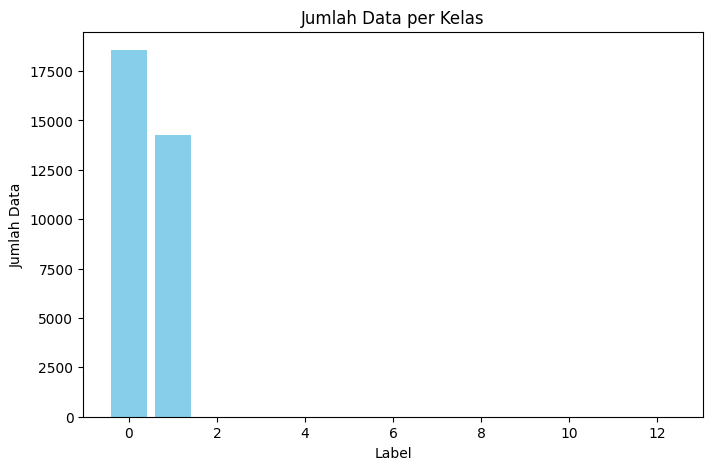

In [ ]:
class_counts = df.groupBy('mode_index').count().orderBy('mode_index')
class_counts.show()

class_counts_pd = class_counts.toPandas()

plt.figure(figsize=(8, 5))
plt.bar(class_counts_pd['mode_index'], class_counts_pd['count'], color='skyblue')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.title('Jumlah Data per Kelas')
plt.show()

+----------+-----+
|mode_index|count|
+----------+-----+
|       0.0|18562|
|       1.0|14254|
+----------+-----+



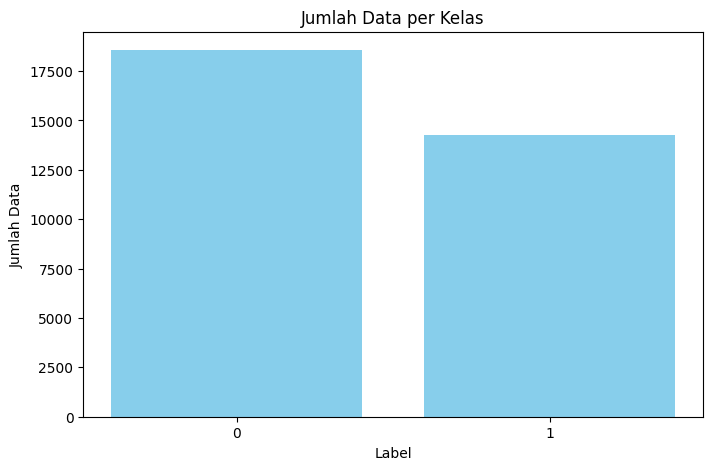

In [ ]:
filtered_df = df.filter((col("mode_index") < 2.0))

class_counts = filtered_df.groupBy('mode_index').count().orderBy('mode_index')
class_counts.show()

class_counts_pd = class_counts.toPandas()

plt.figure(figsize=(8, 5))
plt.bar(class_counts_pd['mode_index'], class_counts_pd['count'], color='skyblue')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.xticks(class_counts_pd['mode_index'])
plt.title('Jumlah Data per Kelas')
plt.show()

In [ ]:
df = filtered_df

In [ ]:
kelas_minoritas = df.groupBy('mode_index').count().orderBy('count').limit(1).select('mode_index').collect()[0]['mode_index']

# Pisahkan kelas minoritas dan mayoritas
df_minoritas = df.filter(col('mode_index') == kelas_minoritas)
df_mayoritas = df.filter(col('mode_index') != kelas_minoritas)

# Hitung rasio kelas minoritas terhadap mayoritas
jumlah_minoritas = df_minoritas.count()
jumlah_mayoritas = df_mayoritas.count()
rasio = float(jumlah_mayoritas / jumlah_minoritas)

# Oversampling kelas minoritas
df_minoritas_oversampled = df_minoritas.sample(withReplacement=True, fraction=rasio, seed=42)

# Gabungkan kelas minoritas yang sudah di-oversampling dengan mayoritas
df_oversampled = df_mayoritas.unionAll(df_minoritas_oversampled)

+----------+-----+
|mode_index|count|
+----------+-----+
|       0.0|18562|
|       1.0|18704|
+----------+-----+



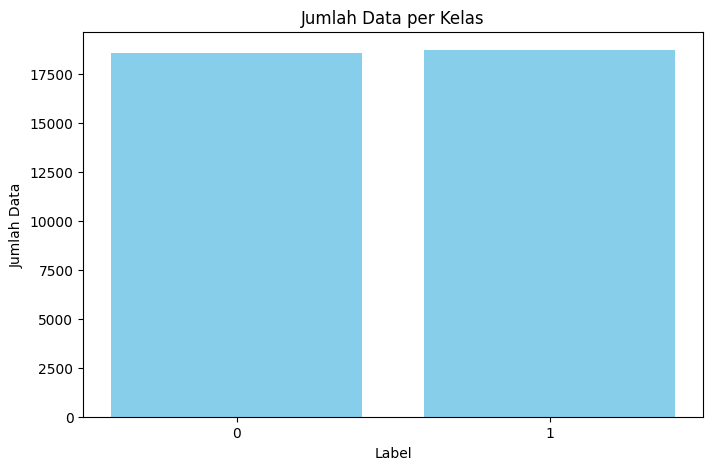

In [ ]:
class_counts = df_oversampled.groupBy('mode_index').count().orderBy('mode_index')
class_counts.show()

class_counts_pd = class_counts.toPandas()

plt.figure(figsize=(8, 5))
plt.bar(class_counts_pd['mode_index'], class_counts_pd['count'], color='skyblue')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.xticks(class_counts_pd['mode_index'])
plt.title('Jumlah Data per Kelas')
plt.show()

## Summary dan Correlation Matrix

In [ ]:
df = df_oversampled

In [ ]:
numeric_features = [t[0] for t in df.dtypes if t[1] in ['int','double']]

# yang diambil hanya kolom yang memiliki fitur numerik
numeric_summary = df.select(numeric_features).summary()
numeric_summary.show(truncate=False)

+-------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|summary|speechiness        |acousticness       |instrumentalness   |liveness           |valence           |tempo             |duration_ms      |danceability_index|energy_index      |key_index         |mode_index        |
+-------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|count  |37266              |37266              |37266              |37266              |37266             |37266             |37266            |37266             |37266             |37266             |37266             |
|mean   |0.10784932109697894|0.17453726445231785|0.08418631687275303|0.19078322224011157|0.5103719736489021|120.

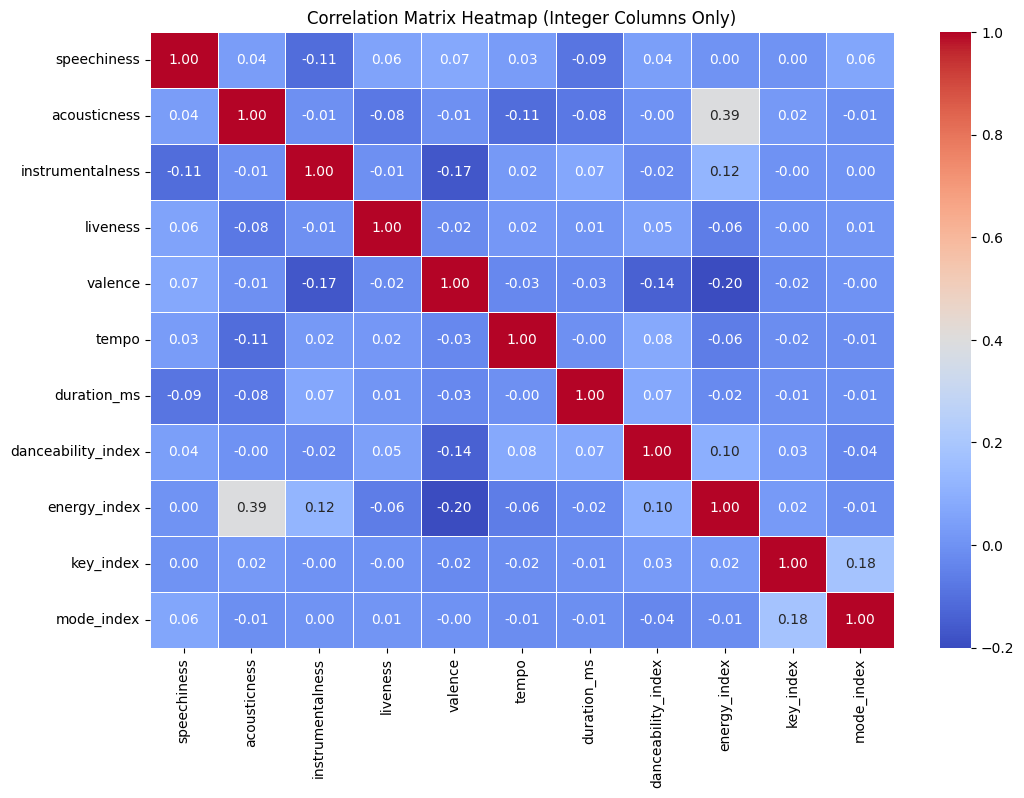

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col
import seaborn as sns
import matplotlib.pyplot as plt

integer_columns = [col_name for col_name, col_type in df.dtypes if col_type in ['int','double']]

vector_assembler = VectorAssembler(inputCols=integer_columns, outputCol="features")

for c in integer_columns:
    median_value = df.approxQuantile(c, [0.5], 0.0)[0]
    df = df.na.fill(median_value, [c])

vector_assembler = VectorAssembler(inputCols=integer_columns, outputCol="features")

df_assembled = vector_assembler.transform(df).select("features")

matrix = Correlation.corr(df_assembled, "features").head()
correlation_matrix = matrix[0].toArray()

correlation_df = pd.DataFrame(correlation_matrix, columns=integer_columns, index=integer_columns)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix Heatmap (Integer Columns Only)")
plt.show()

# **Feature Selection and Splitting**

In [ ]:
# Nama kolom-kolom
feature_columns = ["speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "danceability_index", "energy_index", "key_index"]

# Pisahkan fitur dan label
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df = assembler.transform(df).select('features', 'mode_index')

# Tampilkan hasil
df.show(truncate=False)

+----------------------------------------------------------------------+----------+
|features                                                              |mode_index|
+----------------------------------------------------------------------+----------+
|[0.0356,0.0271,0.0291,0.0799,0.729,109.011,177781.0,79.0,1.0,0.0]     |0.0       |
|[0.249,0.161,0.0,0.114,0.394,163.239,169756.0,342.0,212.0,8.0]        |0.0       |
|[0.0868,9.49E-4,2.94E-4,0.0531,0.787,156.068,143080.0,543.0,427.0,0.0]|0.0       |
|[0.0957,0.0209,8.55E-6,0.0879,0.253,128.942,234653.0,207.0,35.0,5.0]  |0.0       |
|[0.0329,0.0227,1.39E-6,0.229,0.659,124.016,189000.0,160.0,151.0,2.0]  |0.0       |
|[0.0316,0.00563,0.00565,0.138,0.393,127.011,300582.0,84.0,183.0,6.0]  |0.0       |
|[0.0284,0.103,0.197,0.0765,0.443,127.003,282950.0,418.0,125.0,2.0]    |0.0       |
|[0.193,0.0101,0.0,0.343,0.335,149.822,260987.0,458.0,24.0,10.0]       |0.0       |
|[0.0341,0.00959,0.0423,0.112,0.681,128.065,192053.0,276.0,65.0,1.0]   |0.0 

In [ ]:
train, test = df.randomSplit([0.8, 0.2], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 29934
Test Dataset Count: 7332


# **Modelling**

## Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report

# Inisialisasi model Random Forest
rf = RandomForestClassifier(featuresCol='features', labelCol='mode_index', numTrees=50, seed=42)

# Training model
rf_model = rf.fit(train)

# Membuat prediksi
predictions1 = rf_model.transform(test)

# Mendapatkan nilai prediksi dan nilai sebenarnya
y1_true = predictions1.select('mode_index').rdd.flatMap(lambda x: x).collect()
y1_pred = predictions1.select('prediction').rdd.flatMap(lambda x: x).collect()

# Membuat classification report menggunakan scikit-learn
report = classification_report(y1_true, y1_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.64      0.56      0.60      3652
         1.0       0.61      0.69      0.65      3680

    accuracy                           0.63      7332
   macro avg       0.63      0.63      0.62      7332
weighted avg       0.63      0.63      0.62      7332



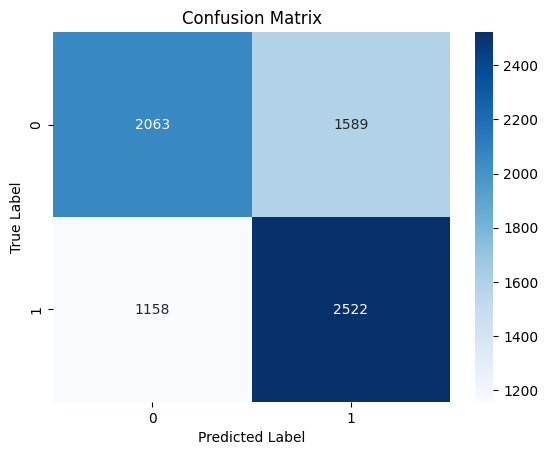

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Tampilkan confusion matrix
sns.heatmap(confusion_matrix(y1_true, y1_pred), annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Logistic Regression

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(featuresCol = 'features', labelCol = 'mode_index', maxIter=10)
lrModel = lr.fit(train)

predictions2 = lrModel.transform(test)

# Mendapatkan nilai prediksi dan nilai sebenarnya
y2_true = predictions2.select('mode_index').rdd.flatMap(lambda x: x).collect()
y2_pred = predictions2.select('prediction').rdd.flatMap(lambda x: x).collect()

# Membuat classification report menggunakan scikit-learn
report = classification_report(y2_true, y2_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.57      0.59      0.58      3652
         1.0       0.58      0.56      0.57      3680

    accuracy                           0.58      7332
   macro avg       0.58      0.58      0.58      7332
weighted avg       0.58      0.58      0.58      7332



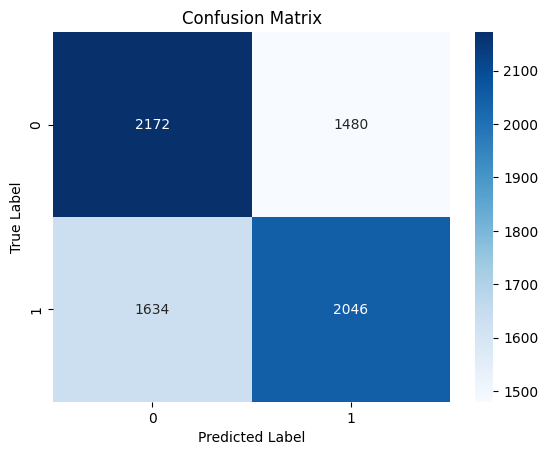

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Tampilkan confusion matrix
sns.heatmap(confusion_matrix(y2_true, y2_pred), annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol='features', labelCol='mode_index', seed=42)
dt_model = dt.fit(train)

predictions3 = dt_model.transform(test)

# Mendapatkan nilai prediksi dan nilai sebenarnya
y3_true = predictions3.select('mode_index').rdd.flatMap(lambda x: x).collect()
y3_pred = predictions3.select('prediction').rdd.flatMap(lambda x: x).collect()

# Membuat classification report menggunakan scikit-learn
report = classification_report(y3_true, y3_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.63      0.69      0.66      3652
         1.0       0.66      0.61      0.63      3680

    accuracy                           0.65      7332
   macro avg       0.65      0.65      0.65      7332
weighted avg       0.65      0.65      0.65      7332



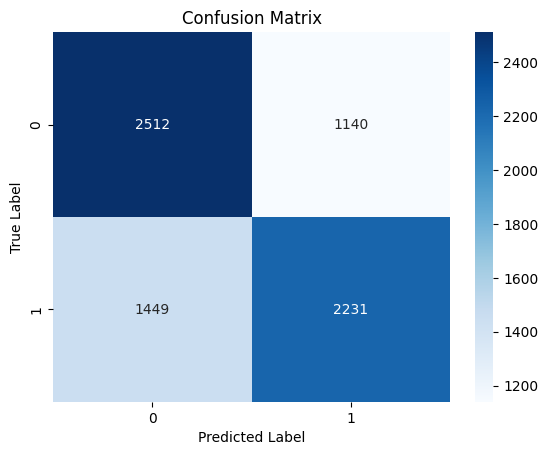

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Tampilkan confusion matrix
sns.heatmap(confusion_matrix(y3_true, y3_pred), annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Gradient-Boosted Tree (GBT)

In [ ]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol='features', labelCol='mode_index', maxDepth=5, maxIter=20, seed=42)
gbt_model = gbt.fit(train)

predictions4 = gbt_model.transform(test)

# Mendapatkan nilai prediksi dan nilai sebenarnya
y4_true = predictions4.select('mode_index').rdd.flatMap(lambda x: x).collect()
y4_pred = predictions4.select('prediction').rdd.flatMap(lambda x: x).collect()

# Membuat classification report menggunakan scikit-learn
report = classification_report(y4_true, y4_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.66      0.69      0.67      3652
         1.0       0.67      0.64      0.66      3680

    accuracy                           0.67      7332
   macro avg       0.67      0.67      0.67      7332
weighted avg       0.67      0.67      0.67      7332



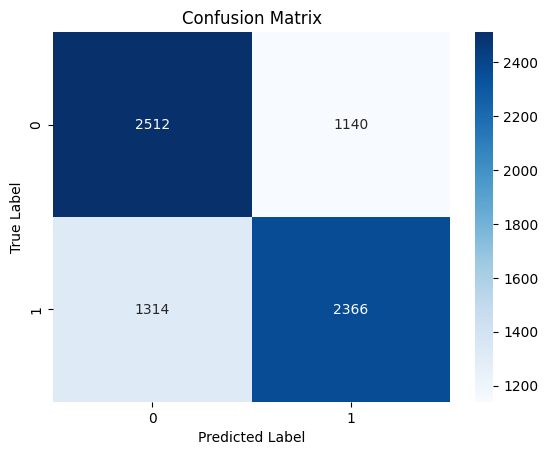

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Tampilkan confusion matrix
sns.heatmap(confusion_matrix(y4_true, y4_pred), annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **Hyperparameter Tunning**

## Decision Tree

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier

# Define your DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol='features', labelCol='mode_index', seed=42)

# Define the parameter grid to search through
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [5, 15, 30])
             .addGrid(dt.maxBins, [32, 45, 60])
             .build())

# Define an evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='mode_index', predictionCol='prediction')

# Create a cross-validator
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # You can adjust the number of folds

# Fit the model
cv_model = crossval.fit(train)

# Get the best model from cross-validation
best_model = cv_model.bestModel

# Make predictions with the best model
predictions = best_model.transform(test)

# Evaluate the model
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1_score}")
print(f"Recall: {recall}")

# Get the best parameters
best_maxDepth = best_model.getMaxDepth()
best_maxBins = best_model.getMaxBins()
print("Best maxDepth:", best_maxDepth)
print("Best maxBins:", best_maxBins)

Accuracy: 0.8011456628477905
Precision: 0.8054990610438011
F1 Score: 0.800374051625683
Recall: 0.8011456628477905
Best maxDepth: 30
Best maxBins: 60


**Tampilan menggunakan classification report**

In [ ]:
from sklearn.metrics import classification_report

# Make predictions with the best model
predictions_dt = best_model.transform(test)

# Get the best parameters
best_maxDepth = best_model.getMaxDepth()
best_maxBins = best_model.getMaxBins()
print("Best maxDepth:", best_maxDepth)
print("Best maxBins:", best_maxBins)

# Convert PySpark DataFrame to Pandas DataFrame
predictions_pd1 = predictions_dt.select('mode_index', 'prediction').toPandas()

# Display classification report
report = classification_report(predictions_pd1['mode_index'], predictions_pd1['prediction'])
print("\n",report)

Best maxDepth: 30
Best maxBins: 60

               precision    recall  f1-score   support

         0.0       0.84      0.74      0.79      3652
         1.0       0.77      0.86      0.81      3680

    accuracy                           0.80      7332
   macro avg       0.81      0.80      0.80      7332
weighted avg       0.81      0.80      0.80      7332



## Gradien-Boosted Tree (GBT)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import GBTClassifier

# Define your GBTClassifier
gbt = GBTClassifier(featuresCol='features', labelCol='mode_index', seed=42)

# Define the parameter grid to search through
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 10, 20])
             .addGrid(gbt.maxBins, [32, 40, 50])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

# Define an evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='mode_index', predictionCol='prediction')

# Create a cross-validator
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # You can adjust the number of folds

# Fit the model
cv_model = crossval.fit(train)

# Get the best model from cross-validation
best_model = cv_model.bestModel

# Make predictions with the best model
predictions = best_model.transform(test)

# Evaluate the model
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1_score}")
print(f"Recall: {recall}")

# Get the best parameters
best_maxDepth = best_model.getMaxDepth()
best_maxBins = best_model.getMaxBins()
best_maxIter = best_model.getMaxIter()
print("Best maxDepth:", best_maxDepth)
print("Best maxBins:", best_maxBins)
print("Best maxIter:", best_maxIter)

Accuracy: 0.8019639934533551
Precision: 0.8054854335303139
F1 Score: 0.8013372923172957
Recall: 0.8019639934533551
Best maxDepth: 20
Best maxBins: 50
Best maxIter: 10


**Tampilan menggunakan classification report**

In [ ]:
from sklearn.metrics import classification_report

# Make predictions with the best model
predictions_gbt = best_model.transform(test)

# Get the best parameters
best_maxDepth = best_model.getMaxDepth()
best_maxBins = best_model.getMaxBins()
best_maxIter = best_model.getMaxIter()
print("Best maxDepth:", best_maxDepth)
print("Best maxBins:", best_maxBins)
print("Best maxIter:", best_maxIter)

# Convert PySpark DataFrame to Pandas DataFrame
predictions_pd2 = predictions_gbt.select('mode_index', 'prediction').toPandas()

# Display classification report
report = classification_report(predictions_pd2['mode_index'], predictions_pd2['prediction'])
print("\n",report)

Best maxDepth: 20
Best maxBins: 50
Best maxIter: 10

               precision    recall  f1-score   support

         0.0       0.84      0.75      0.79      3652
         1.0       0.77      0.86      0.81      3680

    accuracy                           0.80      7332
   macro avg       0.81      0.80      0.80      7332
weighted avg       0.81      0.80      0.80      7332

